In [1]:
# Importing necessary libraries and the preprocess Definition file we created
import tensorflow as tf
import matplotlib.pyplot as plt
import tarfile
import os
from preprocessDefinition import preprocess

In [2]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 299
NUM_CLASSES = 3
TRAIN_SIZE = 1152
VAL_SIZE = 288

In [3]:
# Parsing tfrecord
def parse_examples(serialized_examples):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    examples = tf.io.parse_example(serialized_examples, feature_description)
    image = tf.io.decode_jpeg(examples['image'], channels=3)
    label = examples['label']
    return image, label

In [4]:
# Creating function that loads Dataset provided
def load_dataset(tfrecord_path, repeat=False):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_examples, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset


train_dataset = load_dataset('birds-vs-squirrels-train.tfrecords', repeat=True)
val_dataset = load_dataset('birds-vs-squirrels-validation.tfrecords')

In [5]:
# Creating Model Definition
base_model = tf.keras.applications.Xception(
    include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_model.trainable = False  # freezing base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [6]:
# Training Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=TRAIN_SIZE // BATCH_SIZE,
    validation_steps=VAL_SIZE // BATCH_SIZE,
    callbacks=[early_stop]
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 303s 8s/step - accuracy: 0.9045 - loss: 0.7111 - val_accuracy: 0.9688 - val_loss: 0.5155
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 285s 8s/step - accuracy: 0.9644 - loss: 0.5143 - val_accuracy: 0.9826 - val_loss: 0.4116
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 287s 8s/step - accuracy: 0.9722 - loss: 0.4337 - val_accuracy: 0.9826 - val_loss: 0.3584
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 293s 8s/step - accuracy: 0.9792 - loss: 0.3534 - val_accuracy: 0.9757 - val_loss: 0.3549
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 297s 8s/step - accuracy: 0.9748 - loss: 0.3284 - val_accuracy: 0.9688 - val_loss: 0.3278
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 299s 8s/step - accuracy: 0.9722 - loss: 0.3245 - val_accuracy: 0.9757 - val_loss: 0.2969
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 301s 8s/step - accuracy: 0.9757 - loss: 0.2754 - val_accuracy: 0.9757 - val_loss: 0.2461
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 303s 8s/step - accuracy: 0.9731 - loss: 0.2723 - val_accuracy: 0.9618 - v

In [7]:
# Saving model in zipped version
model_save_path = 'birdsVsSquirrelsModel.keras'
model.save(model_save_path)

archive_name = 'birdsVsSquirrelsModel.tgz'
with tarfile.open(archive_name, "w:gz") as tar:
    tar.add(model_save_path, arcname=os.path.basename(model_save_path))

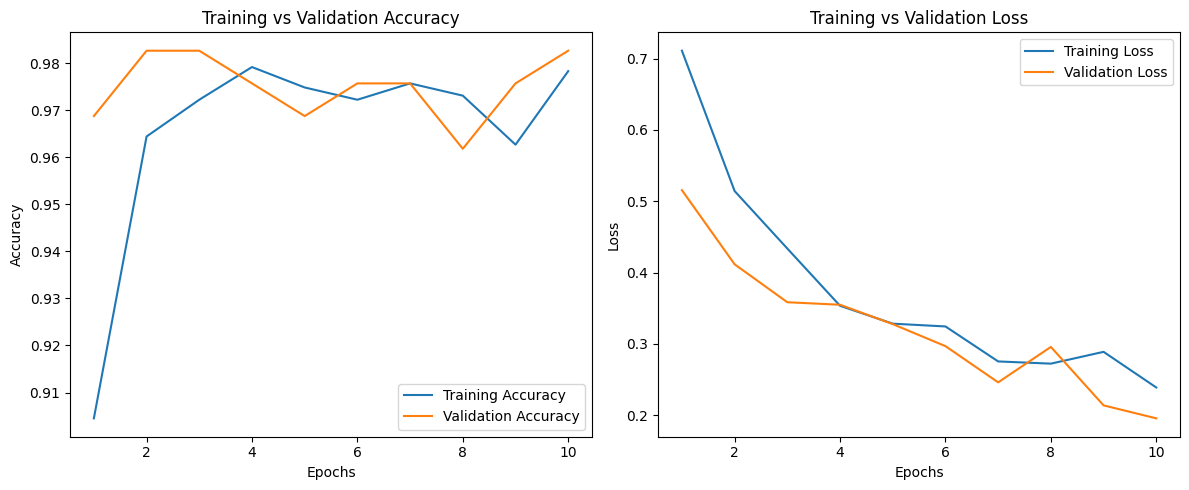

In [8]:
# Plotting Accuracy and loss graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()